<a href="https://colab.research.google.com/github/riyad03/EarthSmart/blob/main/sustainable_consumption_and_production_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

EarthSmart predicts the amount of materials and resources an average person in a country is expected to use over a period. This forecast provides insights into future trends in resource consumption, helping policymakers, businesses, and individuals in making decisions regarding sustainability, resource management, and environmental conservation.
The model is still in developement and it will cover a range of other topics Aligned with Sustainable Development Goal 12, SmartEarth in the future
EarthSmart is developed by Morocco Casablanca GDSC EMSI ORANGERS team: Riyad Rachidi, Souhail Fairadi, Mouhcine hakim,  Anass Amazzar.




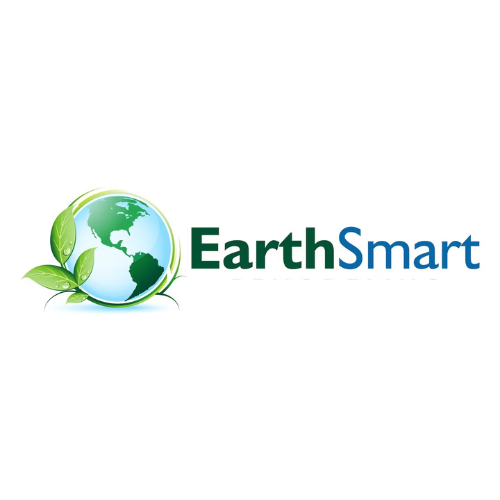

##Data PreProcessing

In [204]:
import pandas as pd
from pandas import read_csv
import tqdm as tqdm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [205]:
df=read_csv('/content/domestic-material-consumption-per-capita (1).csv',header=0)

In [206]:
df.drop(df.columns[1],inplace=True,axis=1)

In [207]:
df

,Entity,Year,"12.2.2 - Domestic material consumption per capita, by type of raw material (tonnes) - EN_MAT_DOMCMPC - Total or no breakdown"
0,Afghanistan,2000,1.17
1,Afghanistan,2001,1.08
2,Afghanistan,2002,1.33
3,Afghanistan,2003,1.35
4,Afghanistan,2004,1.21
...,...,...,...
4413,Zimbabwe,2015,5.27
4414,Zimbabwe,2016,5.30
4415,Zimbabwe,2017,5.40
4416,Zimbabwe,2018,5.76


In [208]:
values=df.values

In [209]:
data=[]
element='Afghanistan'
val=[]
for i in tqdm.tqdm(range(len(values))):

  val.append(values[i,2])
  if i!=len(values)-1:
    if values[i+1,0]!=element:
      val=np.array(val)
      data.append(val)
      element=values[i+1,0]
      val=[]
  else:
    val=np.array(val)
    data.append(val)


100%|██████████| 4418/4418 [00:00<00:00, 680765.43it/s]


In [ ]:
len(data)

222

In [210]:
scaler=MinMaxScaler(feature_range=(0,1))
scalelist=[]
for i in range(len(data)):
  scalelist.append(scaler.fit_transform(pd.DataFrame(data[i])))


In [ ]:
scalelist

In [ ]:
len(scalelist)

222

In [211]:
def ToSupervised(dt,past_time=-1,future_time=3):
  df=pd.DataFrame(dt)
  if past_time<0:
    past_time=-past_time
  col,names=[],[]
  for i in range(past_time,0,-1):
    col.append(df.shift(i))
    names+=['t -'+str(i)]
  for i in range(0,future_time):
    col.append(df.shift(-i))
    names+=['t +'+str(i)]
  agg=pd.concat(col,axis=1)
  agg.columns=names
  agg.dropna(inplace=True)
  return agg.values


In [212]:
reframe=[]
for i in range(len(scalelist)):
  reframe.append(ToSupervised(scalelist[i],-3,3))

In [ ]:
reframe

In [ ]:
lastel=reframe.pop(-1)

In [ ]:
reframe[0][0]

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789])

In [213]:
train=reframe[:92]
test=reframe[92:]

##Model Training

In [214]:
model = Sequential()
model.add(LSTM(15, input_shape=(1, 5)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
records=[]
for i in range(46):
  print('train num',i)
  x=train
  t=train[46:]
  x=train[:46]
  if not (x[i].any() and t[i].any()):
    continue
  train_x,train_y=x[i][:,:-1],x[i][:,-1:]
  val_x,val_y=t[i][:,:-1],t[i][:,-1:]
  train_x=train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
  val_x=val_x.reshape((val_x.shape[0],1,val_x.shape[1]))
  hist=model.fit(train_x,train_y,validation_data=(val_x,val_y),batch_size=28,verbose=1,epochs=20,shuffle=False)
  records.append(hist)

In [ ]:
rmse_record=[]
for i in range(len(test)):
  t=test
  test_x=t[i][:,:-1]
  test_y=t[i][:,-1]
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  yhat=model.predict(test_x)
  test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_x[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_x[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  rmse_record.append(np.sqrt(mean_squared_error(inv_y, inv_yhat)))

In [ ]:
rmse_record

##Model Testing

In [216]:
t=[	7.31,	7.63,7.94,8.39,9.11]
t = np.array(t).reshape(-1, 1)
scaling= MinMaxScaler()
t=scaler.fit_transform(t)
t=np.array(t)
t= t.reshape((t.shape[1], 1, t.shape[0]))
yhat=model.predict(t)

1/1 [==============================] - 1s 920ms/step


In [217]:
#convert the prediction back
t = t.reshape((t.shape[0],t.shape[2]))
inv_yhat = np.concatenate((yhat, t[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [218]:
inv_yhat

array([8.56380483])

In [ ]:
model.save("sustainable consumption and production.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test for countries

In [ ]:
ent='Afghanistan'
entlist=[ent]
for i in tqdm.tqdm(range(len(df))):
  if(ent != df['Entity'].values[i]):
    ent=df['Entity'].values[i]
    entlist.append(ent)


100%|██████████| 4418/4418 [00:00<00:00, 141558.52it/s]


In [ ]:
from keras import models

renewable= models.load_model("/content/sustainable consumption and production.h5")

In [ ]:
entlistindex=0
newdata=["Entity,Year,(% equivalent primary energy)"]
while(entlistindex<len(entlist)):

  lastdata=[]
  #add 5 last data
  lastdata.append(df[df['Entity']==entlist[entlistindex]].tail(5).values[:,-1].tolist())
  year=2020
  while (year<=2027):
    newtest=lastdata[0]

    #standardize
    newtest=np.array(newtest).reshape(-1,1)
    scaler=MinMaxScaler(feature_range=(0,1))
    newtest=scaler.fit_transform(newtest)
    newtest=np.array(newtest)
    #reshape
    newtest=newtest.reshape(newtest.shape[1],1,newtest.shape[0])
    if(newtest.shape!=(1,1,5)):
      break
    #prediction
    ypred= renewable.predict(newtest)
    #inverse prediction
    newtest = newtest.reshape((newtest.shape[0],newtest.shape[2]))
    inv_yhat = np.concatenate((ypred, newtest[:, 1:]), axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    lastdata[0].append(inv_yhat[0])
    lastdata=[lastdata[0][1:]]

    newdata.append(entlist[entlistindex]+","+str(year)+","+str(inv_yhat[0]))
    print(year," ",entlistindex)
    year=year+1
  entlistindex=entlistindex+1


In [ ]:
entlistindex

100

In [ ]:
newdata

In [ ]:
import csv
with open('predictions.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in newdata:
        csvwriter.writerow(row.split(','))